In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.wcs import WCS
from astropy.io import fits

from gzjwst import chisq_utils

from scipy.stats import truncnorm, norm
# from scipy.optimize import minimize

In [3]:
filter_band_kwarg = 'f200w'
# filter_band_kwarg = 'f277w'
list_of_relevant_files = glob.glob('/home/walml/repos/gz-jwst/data/dev_data/hlsp_ceers*{}*i2d.fits.gz'.format(filter_band_kwarg))
filename = list_of_relevant_files[0]
fits_ext = 2  # TODO

In [4]:
filename

'/home/walml/repos/gz-jwst/data/dev_data/hlsp_ceers_jwst_nircam_nircam6_f200w_v0.5_i2d.fits.gz'

In [5]:
# _, image_header = fits.getdata(filename, memmap=True, ext=2, header=True)
# image_wcs = WCS(image_header)

In [6]:


# https://archive.stsci.edu/hlsps/ceers/hlsp_ceers_jwst_nircam-miri_multi_multi_v0.6_readme.txt

"""The NIRCam images are multi-extension fits files with 13 extensions:
  0. PRIMARY header
  1. SCI_BKSUB  - 2D background-subtracted science image
  2. SCI  - 2D science image (not background subtracted)
  3. ERR  - 2D array of uncertainties, given as standard deviation and
            constructed as the sum in quadrature of the resampled variance maps
  4. CON  - 2D context image, encoding info about which input images
            contribution to each output pixel
  5. WHT  - 2D weight image giving the relative weight of the output pixels,
            constructed from the VAR_RNOISE map during resampling
  6. VAR_POISSON  - 2D variance array based on Poisson noise only
  7. VAR_RNOISE  - 2D variance array based on read noise only
  8. VAR_FLAT  - 2D variance array based on uncertainty in the flat-field
  9. BKGD  - 2D background model subtracted from the science image
 10. BKGMASK  - the tiered source mask used to create the background
 11. HDRTAB  - table containing metadata (FITS keyword values) for all the
               input images
 12. ASDF  - metadata for the JWST data model
"""

# note that science image is already background-subtracted, no need to do more background subtraction
# but we might use these to check the subtraction is reasonable
background_info = {
    # 'science_image': fits.getdata(filename, memmap=True, ext=2),
    'science_image_bkg_subtracted': fits.getdata(filename, memmap=True, ext=1),
    # 'background': fits.getdata(filename, memmap=True, ext=9),
    'background_source_mask': fits.getdata(filename, memmap=True, ext=10),
    # 'uncertainties': fits.getdata(filename, memmap=True, ext=3)
}


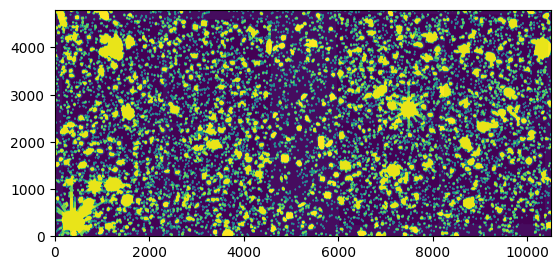

In [7]:
plt.imshow(background_info['background_source_mask'], origin='lower')

(array([5.0399625e+07, 2.8000000e+02, 5.6000000e+01, 1.0000000e+01,
        1.3000000e+01, 7.0000000e+00, 4.0000000e+00, 3.0000000e+00,
        0.0000000e+00, 2.0000000e+00]),
 array([ -1.55084405,  66.96851632, 135.4878767 , 204.00723707,
        272.52659745, 341.04595782, 409.5653182 , 478.08467857,
        546.60403894, 615.12339932, 683.64275969]),
 <BarContainer object of 10 artists>)

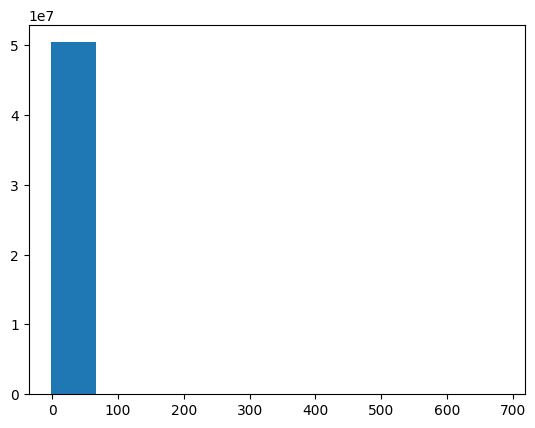

In [8]:
plt.hist(background_info['science_image_bkg_subtracted'].flatten())

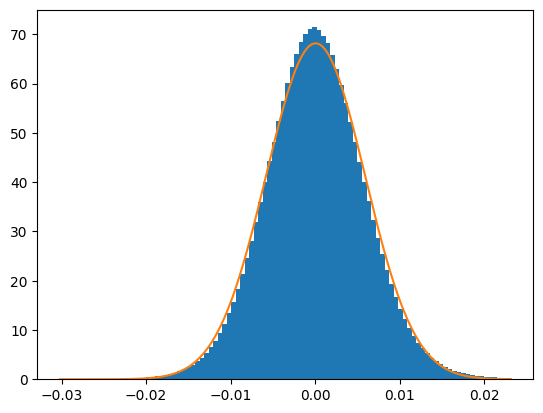

In [23]:

random_image = chisq_utils.get_alleged_random_background_image(
    background_info['science_image_bkg_subtracted'],
    background_info['background_source_mask']
)


# low_mode = np.percentile(random_image, 10.)
# high_mode = np.percentile(random_image, 90.)
# assert low_mode < high_mode
# safe_to_fit = random_image[(random_image > low_mode) & (random_image < high_mode)]
# this breaks the rule-of-thumb approach as now it becomes a truncated normal


scale = chisq_utils.std_estimator(random_image)
loc = np.mean(random_image)

_ = plt.hist(random_image, bins=100, density=True)

x = np.linspace(random_image.min(), random_image.max(), 1000)
# scale = 0.00565
y = norm.pdf(x, loc=loc, scale=scale)
plt.plot(x, y)

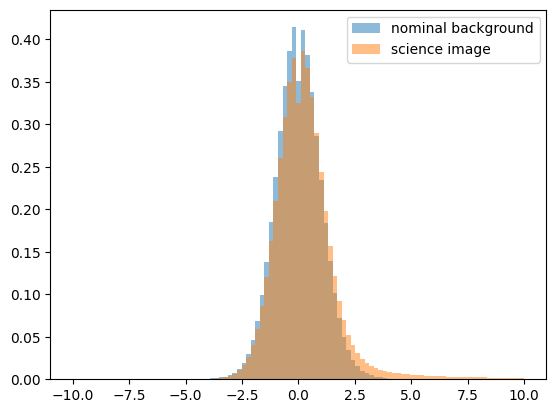

In [24]:
min_pixel_value = 0.0001
bins = np.linspace(-10, 10, 100)

_ = plt.hist(
    random_image[np.abs(random_image) > min_pixel_value].flatten() / scale,
    bins=bins,
    density=True,
    alpha=.5, 
    label='nominal background'
)

science_image = background_info['science_image_bkg_subtracted']
_ = plt.hist(
    science_image[np.abs(science_image) > min_pixel_value].flatten() / scale,
    bins=bins,
    density=True,
    alpha=.5, 
    label='science image'
)

plt.legend()

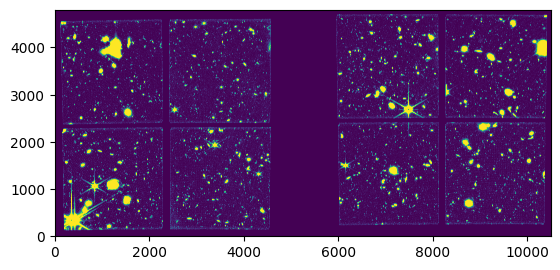

In [25]:
plt.imshow((science_image / scale) > 2, origin='lower')

In [26]:

# bins = np.linspace(-10, 10, 100)
# _ = plt.hist(
#     random_image[random_image > min_pixel_value].flatten() / scale,
#     bins=bins,
#     density=True,
#     alpha=.5, 
#     label='nominal background'
# )


# science_image = background_info['science_image_bkg_subtracted']
# _ = plt.hist(
#     science_image[science_image > min_pixel_value].flatten() / scale,
#     bins=bins,
#     density=True,
#     alpha=.5, 
#     label='science image'
# )


# x = np.linspace(0., 10, 1000)
# y = norm.pdf(x, scale=1) * 2  # half-normal
# plt.plot(x, y, label='half normal')

# plt.legend()

In [27]:


# # def halfnorm_logpdf(x, scale):
# #     return truncnorm.logpdf(x, scale=scale, a=low_mode/scale, b=high_mode/scale)

# # def halfnorm_log_likelihood(x, scale):
# #     return np.sum(halfnorm_logpdf(x, scale))


# def norm_logpdf(x, scale):
#     print(len(x), x.mean(), x.std())
#     # return truncnorm.logpdf(x, scale=scale, a=low_mode/scale, b=high_mode/scale)
#     return norm.logpdf(x, scale=scale)

# def norm_log_likelihood(x, scale):
#     return np.sum(norm_logpdf(x, scale))

# def fit_standard_deviation_of_faint_pixels(random_image, low_mode, high_mode, max_pixels=1e6):
#     # random_image should be the background-subtracted science image, with sources masked
#     # in principle this is now random gaussian (okay poisson) noise, with an unknown standard deviation

#     # print(safe_to_fit.mean(), safe_to_fit.std())
#     # safe_to_fit.shape, safe_to_fit.min(), safe_to_fit.max()

#     if safe_to_fit.size > max_pixels:
#         safe_to_fit = safe_to_fit[np.random.choice(safe_to_fit.size, int(max_pixels), replace=False)]

#     # fit a half-normal gaussian with 0 mean and unknown standard deviation
#     result = minimize(
#         lambda x: -norm_log_likelihood(safe_to_fit, x),
#         x0 = [0.003],
#         constraints=[
#             {'type': 'ineq', 'fun': lambda x: x[0]}  # inequality means non-negative, implying non-negative std
#         ]
#     )

#     assert result.success, result

#     return result.x[0]  # return the best-fitting standard deviation

# # low_mode = 1e-4
# # low_mode = 1e-4
# # high_mode = 0.005

# std_of_random_image = fit_standard_deviation_of_faint_pixels(
#     random_image,
#     low_mode=low_mode,
#     high_mode=high_mode
# )

# bins = np.linspace(low_mode, high_mode, 100)
# _ = plt.hist(
#     random_image.flatten(),
#     bins=bins,
#     density=True
# )

# plt.axvline(low_mode, color='red')

# plt.axvline(high_mode, color='green')

# x = np.linspace(low_mode, high_mode, 1000)
# # scale = 0.00565
# y = truncnorm.pdf(x, scale=std_of_random_image, a=low_mode/std_of_random_image, b=high_mode/std_of_random_image)
# plt.plot(x, y)


In [28]:

# for chi-sq image, run this on each band to normalise, then sum the square of the individual pixel values for the y detection image
# (then optionally square-root for the R detection image)
# and run source detection as normal (with no further background subtraction, as the image is p of source in pixel)